In [4]:
import sys
import os
import numpy as np
import importlib
sys.path.insert(0, '.\src')
import config
import cv2
from helpers import extract_first_number
import time
import argparse
import pandas as pd
import shap
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from thermal_input_generator import generate_thermal_input
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

In [214]:
importlib.reload(classifier)
importlib.reload(cv_input_generator)

<module 'classifier' from 'C:\\Users\\DPL_QS_Felix Ajakaiy\\Downloads\\test-project-master\\.\\src\\classifier.py'>

In [104]:
# number of iterations
LBFGS_ITERATIONS = 1000
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def main_cv():
    '''
    Classifies the computer vision features only
    '''
    all_datafiles = [participant + '-' + str(i) for participant in config.PARTICIPANTS for i in range(config.LOWER_FILE_INDEX, config.UPPER_FILE_INDEX + 1)]
    all_labels = [extract_first_number(i) for i in all_datafiles]
    stratified_cross_validation(np.zeros(len(all_labels)), all_labels, feature_names=config.OPENCV_FEATURES)
    
def main_thermal():
    '''
    Classifies the thermal features only
    '''
    # calls generate thermal input function
    data, labels = generate_thermal_input()
    # cross validates data and labels
    stratified_cross_validation(data, labels, feature_names=config.THERMAL_FEATURES)
   
def main_combined():
    '''
    Classifies the thermal and the computer vision features
    @Parameters
        random_state: int
            the random state to split the data into testing and training data
    '''
    all_datafiles = [participant + '-' + str(i) for participant in config.PARTICIPANTS for i in range(config.LOWER_FILE_INDEX, config.UPPER_FILE_INDEX + 1)]
    all_labels = [extract_first_number(i) for i in all_datafiles]
    stratified_cross_validation(np.zeros(len(all_labels)), all_labels, feature_names=config.ALL_FEATURES)
    
def stratified_cross_validation(data, labels, feature_names, k=config.CROSS_VALIDATION_K):
    '''
    Stratified k fold cross validation
    @Parameters
        data: array of float of shape (n_samples, n_features)
            the input data to be classified
        labels: array of int of shape (n_samples, )
            the classes of the data
        k: int
            the number of folds
    '''
    # take the start time
    start = time.time()
    X = np.array(data)
    y = np.array(labels)
    # define stratified k fold
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    # initialize measure lists
    accs, precs, f1s, recs, aucs, mats = [], [], [], [], [], []
    list_shap_values = list()
    list_indexes = list()
    # for every fold in the cross validation
    for train_index, test_index in skf.split(X, y):
        # if opencv classification
        if feature_names == config.OPENCV_FEATURES:
            x_train, x_test, y_train, y_test, _, _ = generate_cv_input(train_index, test_index)
            X = np.concatenate((x_train, x_test))
        # if thermal classification
        elif feature_names == config.THERMAL_FEATURES:
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        # if combined classification
        else:
            x_train, x_test, y_train, y_test = generate_combined_features(train_index, test_index)
            X = np.concatenate((x_train, x_test))
        # define logistic regression classifier
        clf = LogisticRegression(multi_class='ovr', max_iter=LBFGS_ITERATIONS, solver='lbfgs')
        # train the classifier
        clf.fit(x_train, y_train)
        # predict labels of x_test
        y_pred = clf.predict(x_test)
        # predict probabilities of labels of x_test (used for AUC)
        y_pred_proba = clf.predict_proba(x_test)
        # calculate measures and add them to lists
        aucs.append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0))
        f1s.append(f1_score(y_test, y_pred, labels=np.unique(y_test), average='weighted'))
        recs.append(recall_score(y_test, y_pred, labels=np.unique(y_test), average='weighted'))
        mats.append(confusion_matrix(y_test, y_pred, labels=np.unique(y_test), normalize='true'))
        # get shap explainer for this k fold iteration
        explainer = shap.Explainer(clf, x_train) # get shap explainer for this k fold iteration
        # compute shap values on train data
        shap_values = explainer.shap_values(x_train)
        # append the shap values to list
        list_shap_values.append(shap_values)
        list_indexes.append(train_index)
    end = time.time()
    measures = dict()
    measures['mean acc'] = np.mean(accs)
    measures['std acc'] = np.std(accs)
    measures['mean prec '] = np.mean(precs)
    measures['std prec'] = np.std(precs)
    measures['mean f1 '] = np.mean(f1s)
    measures['std f1'] = np.std(f1s)
    measures['mean recall'] = np.mean(recs)
    measures['std recall'] = np.std(recs)
    measures['mean auc'] = np.mean(aucs)
    measures['std auc'] = np.std(aucs)
    measures['computing time'] = end - start
    avg_mat = np.mean(mats, axis=0)
    #my_plot_confusion_matrix(avg_mat, np.mean(accs), show=False)
    #save_cross_val_feature_importance_graph(list_shap_values, list_indexes, X, feature_names=feature_names)
    print_classifier_report(measures, 'ovr stratified k fold')

def print_classifier_report(measures, classifier_name):
    '''
    Print the results of a classifier
    @Parameters
        measures: dictionary
            all measures with their values that should be reported
        classifier_name: string
            the name of the classifier
    '''
    print(' ########## CLASSIFIER RESULTS ##########')
    print('CLASSIFIER: ', classifier_name.upper())
    print('FEATURE SET: ', config.FEATURE_SET)
    print('LOWER/UPPER FILE INDEX: {}/{}'.format(str(config.LOWER_FILE_INDEX), str(config.UPPER_FILE_INDEX)))
    for key, values in measures.items():
        print('{} : {}'.format(key, str(values)))

def save_cross_val_feature_importance_graph(shap_value_list, index_list, X, feature_names):
    '''
    saves and generates a feature importance graph from multiple SHAP values computed in k fold cross validation
    @Parameters
        shap_value_list: array of shape (k_folds, 20, n_samples, n_features)
            the generated shap values of all samples over all features and all folds
        index_list: array of shape (k_folds, n_samples)
            the list of all indexes that were used for shap feature importance graph
    
    Code derived from:
        Title: Visualizing variable importance using SHAP and cross-validation
        Author: Lucas Ramos
        Date: 26.06.2020
        Availability: https://lucasramos-34338.medium.com/visualizing-variable-importance-using-shap-and-cross-validation-bd5075e9063a
    '''
    #combining results from all iterations
    test_set = index_list[0]
    shap_values = np.array(shap_value_list[0])
    for i in range(1,len(index_list)):
        test_set = np.concatenate((test_set, index_list[i]),axis=0)
        shap_values = np.concatenate((shap_values, np.array(shap_value_list[i])),axis=1)
    pd_frame = pd.DataFrame(X[test_set], columns=feature_names)
    plt.figure()
    shap.summary_plot(shap_values[1], pd_frame, show=False, plot_type='bar', max_display=10)
    plt.savefig(os.path.join(config.CLASSIFIER_PLOT_PATH, 'cross_val_shap_train.png'))
       
def my_plot_confusion_matrix(matrix, accuracy, show=True):
    '''
    Plots a confusion matrix to the command line
    @Parameters
        matrix: Matrix
            The confusion matrix obtained from sklearn
        accuracy: float
            The accuracy score from the classifier
        classifier_name: str
            The name of the classifier used (rbf, ovr, poly)
    @Returns
        None
    '''
    plt.figure(figsize=(9,9))
    sns.heatmap(matrix, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=list(range(1,len(config.PARTICIPANTS) + 1)), yticklabels=list(range(1,len(config.PARTICIPANTS) + 1)), annot_kws={"fontsize": 8})
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {}'.format(np.round(accuracy,4))
    plt.title(all_sample_title, size = 15)
    plt.savefig(os.path.join(config.CLASSIFIER_PLOT_PATH, 'confusion_matrix.png'))
    if show:
        plt.show()

def generate_combined_features(train_index, test_index):
    '''
    generates the combined opencv and thermal feature vectors split in testing and training data
    @Parameters
        train_index: ndarray of int
            The training indices in the data
        test_index: ndarray of int
            The testing indices in the data
    @Returns
        X_train_all: training data
        X_test_all: testing data
        y_train: training data labels
        y_test: testing data labels
    '''
    X_train, X_test, y_train, y_test, train_names, test_names = generate_cv_input(train_index, test_index)
    X_train_all = []
    X_test_all = []
    
    # add thermal features to train data
    for index, name in enumerate(train_names):
        # load thermal data from feature files
        data = np.load(os.path.join(config.THERMAL_PATH, name + '.npy'), allow_pickle=True)
        # for alle frames (1 frame = 1 sample)
        for i in range(0,config.FRAMES_PER_PROCESS):
            # make sure that the label is set correctly, else throw Exception
            if y_train[index*config.FRAMES_PER_PROCESS+i] != extract_first_number(name):
                raise Exception("Labels didnt match for ", name, ": y was ", y_train[index*config.FRAMES_PER_PROCESS+i])
            # append cv features of current frame and thermal features to array
            X_train_all.append(np.hstack((X_train[index * config.FRAMES_PER_PROCESS + i], np.array(data))))
            
    # do the same for the testing data
    for index, name in enumerate(test_names):
        data = np.load(os.path.join(config.THERMAL_PATH, name + '.npy'), allow_pickle=True)
        for i in range(0,config.FRAMES_PER_PROCESS):
            if y_test[index*config.FRAMES_PER_PROCESS+i] != extract_first_number(name):
                raise Exception("Labels didnt match for ", name, ": y was ", y_test[index*config.FRAMES_PER_PROCESS+i])
            X_test_all.append(np.hstack((X_test[index*config.FRAMES_PER_PROCESS + i], np.array(data))))
    # vertically stack testing and training data
    X_train_all = np.vstack(X_train_all)
    X_test_all = np.vstack(X_test_all)
    return X_train_all, X_test_all, y_train, y_test

'''
if __name__ == "__main__":
    # argument parser to execute all combinations from command line
    parser = argparse.ArgumentParser()
    parser.add_argument('-l', '--lower', help="lower file index", type=int, default=config.LOWER_FILE_INDEX)
    parser.add_argument('-u', '--upper', help="upper file index", type=int, default=config.UPPER_FILE_INDEX)
    args = parser.parse_args(sys.argv[2:])
    # save lower and upper file index to config
    config.LOWER_FILE_INDEX = args.lower
    config.UPPER_FILE_INDEX = args.upper
    
    # choose classifier, either thermal, computer vision, or combined
    if len(sys.argv) > 1:
        if re.search(r'thermal', sys.argv[1], re.IGNORECASE):
            config.FEATURE_SET = 'THERMAL'
            main_thermal()
        elif re.search(r'cv|vision', sys.argv[1], re.IGNORECASE):
            config.FEATURE_SET = 'OPENCV'
            main_cv()
        elif re.search(r'both|all|combined', sys.argv[1], re.IGNORECASE):
            main_combined()
        else:
            raise NameError('Your argument is not valid. It must be either "thermal", "opencv" or "both"')
    else:
        main_combined()
        
'''


'\nif __name__ == "__main__":\n    # argument parser to execute all combinations from command line\n    parser = argparse.ArgumentParser()\n    parser.add_argument(\'-l\', \'--lower\', help="lower file index", type=int, default=config.LOWER_FILE_INDEX)\n    parser.add_argument(\'-u\', \'--upper\', help="upper file index", type=int, default=config.UPPER_FILE_INDEX)\n    args = parser.parse_args(sys.argv[2:])\n    # save lower and upper file index to config\n    config.LOWER_FILE_INDEX = args.lower\n    config.UPPER_FILE_INDEX = args.upper\n    \n    # choose classifier, either thermal, computer vision, or combined\n    if len(sys.argv) > 1:\n        if re.search(r\'thermal\', sys.argv[1], re.IGNORECASE):\n            config.FEATURE_SET = \'THERMAL\'\n            main_thermal()\n        elif re.search(r\'cv|vision\', sys.argv[1], re.IGNORECASE):\n            config.FEATURE_SET = \'OPENCV\'\n            main_cv()\n        elif re.search(r\'both|all|combined\', sys.argv[1], re.IGNORECASE):

In [6]:
def split_in_testing_and_training_data(train_index, test_index, random_state=None):
    '''
    splits the datafile names and labels into testing and training data
    @Parameters
        test_size: float in range(0,1)
            The proportion of the test data to the total data
        random_state: int
            Random seed passed to sklearn function
    @Returns
        X_train: list of string
            the datafile names of the training data
        X_test: list of string
            the datafule names of the testing data
    '''
    all_datafiles = np.array([participant + '-' + str(i) for participant in config.PARTICIPANTS for i in range(config.LOWER_FILE_INDEX, config.UPPER_FILE_INDEX+1)])
    train_files = all_datafiles[train_index]
    test_files = all_datafiles[test_index]
    return train_files, test_files

def generate_descriptors_labels(X_train, X_test):
    '''
    generates the descriptors and labels of the testing and training data
    @Parameters
        X_train: list of string
            the names of the datafiles in the training data
        X_test: list of string
            the names of the datafiles in the testing data
    @Returns
        data_label_dict: dict of array of shape (2,1)
            The dict that contains the descriptors and label to every datafile name
        train_data: array of shape (n_train_samples, n_descriptors)
            An array that contains all descriptors of the training data
    '''
    train_data = []
    data_label_dict = dict()
    for file in np.concatenate((X_train, X_test)):
        label = extract_first_number(file)
        # load the descriptors from the descriptor files
        descriptors = np.load(os.path.join(config.DES_PATH, file + '.npy'), allow_pickle=True)
        data_label_dict[file] = [descriptors, label]
        for des in descriptors:
            if file in X_train:
                if des is None:
                    continue
                train_data.append(des)
    #print("$$$$$$$$$$$$$$$$$$$$$")
    #del train_data[28]
    train_data= [np.float32(data) for data in train_data]
    
    #print("train data--->",np.shape(train_data[0]))
    #print("train data--->",np.shape(train_data[1]))
    #print("train data 28--->",np.shape(train_data[28]))
    #print("train data 100--->",np.shape(train_data[100]))
    #print("train data--->",(train_data[28]))          
    train_data = np.vstack(train_data)
    #print(np.shape(train_data))
    return data_label_dict, train_data

def k_mean_clustering(features, k=config.K_MEANS_K):
    '''
    k mean clustering algorithm for finding centres within the features
    @Parameters
        features: 2-dim array
            The features that the centre should be found of
        k: int
            Number of centres to find
    @Rreturns
        centres: array of same shape as features
            The common centres that were found
    '''
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, centres = cv2.kmeans(features, k, None, criteria, 10, flags)
    return centres


def bag_of_features(features, centres, k=config.K_MEANS_K):
    '''
    similar algorithm to bag of words in NLU.
    Counts the occurrence of common centres in the features
    @Parameter
        features: 2-dim array
            the feature vector that is passed
        centres: 2-dim array
            the centres that are compared to the features
        k: int
            amount of points that should be compared
    @Returns
        vec: 2-dim array that has the count of feature occurrence in it
    
    Code derived from:
        Title: Image Classification using SIFT
        Author: Akhilesh Sharma
        Date: 27.11.2020
        Availability: https://github.com/Akhilesh64/Image-Classification-using-SIFT/blob/main/main.py
    '''
    # initialize with array of size k with all values being 0
    vec = np.zeros((1, k))
    # vertically stack the features
    #print("Feature $$$$$$$$$ --->",features)
    #features[features == None] = 0
    #features= [np.float32(data) for data in features]
    features = np.vstack(features)
    # for all feature points
    for i in range(features.shape[0]):
        feat = features[i]
        # calculate the difference of the tiled features to the centres
        # tile repeats the feat (k,1) times
        diff = np.tile(feat, (k, 1)) - centres
        # calculate the distances
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        # get sorted index array of the distance array
        idx_dist = dist.argsort()
        # take the index of the smallest distance
        idx = idx_dist[0]
        # increase the vec at this position by 1
        vec[0][idx] += 1
    return vec
        
def generate_cv_input(train_index, test_index, random_state=None):
    '''
    Main function of this module
    Generates the computer vision inputs from the feature files
    @Parameters
        random_state: int
            Random seed passed to split the data
        test_size: float in range (0,1)
            Proportion of the testing size to total size
    @Returns
        train_vec: array of size (n_train_samples, n_cv_features)
            the training input data
        test_vec: array of size (n_test_samples, n_cv_features)
            the testing input data
        train_labels: array of int of size (n_train_samples, 1)
            the training labels
        test_labels: array of int of size (n_test_samples, 1)
            the testing labels
        X_train: array of string of size (n_train_samples, 1)
            names of the training data files ordered
        X_test: array of string of size (n_test_samples, 1)
            names of the testing data files ordered
    '''
    # generates testing and training data names
    X_train, X_test = split_in_testing_and_training_data(train_index, test_index, random_state=random_state)
    # generates [des, label] - dict and training data array
    #print("X_TRAIN: ", X_train)
    #print("X_TEST: ", X_test)
    dictionary, train_data = generate_descriptors_labels(X_train, X_test)
    # finds centres by using k_mean_clustering among the training data
    #print("train data ------->",train_data)
    #print("train data max------->",(np.max(train_data)))
    #print("train data min------->",(np.min(train_data)))
    #print("train data shape------->",(np.shape(train_data)))
    centres = k_mean_clustering(train_data)
    test_labels = []
    test_vec = []
    train_labels = []
    train_vec = []
    # for all testing files
    for test_file in X_test:
        # for all descriptors from the testing file (one descriptor per frame)
        for des in dictionary[test_file][0]:
            # applies bag of features to current descriptors, comparing with centres
            if des is None:
                continue
            img_vec = bag_of_features(des, centres)
            # append to testing vector
            test_vec.append(img_vec)
            # append to label list
            test_labels.append(dictionary[test_file][1])
    # do the same for all training data
    for train_file in X_train:
        for des in dictionary[train_file][0]:
            if des is None:
                continue
            img_vec = bag_of_features(des, centres)
            train_vec.append(img_vec)
            train_labels.append(dictionary[train_file][1])
    # vertically stack the vectors
    test_vec = np.vstack(test_vec)
    train_vec = np.vstack(train_vec)
    return train_vec, test_vec, train_labels, test_labels, X_train, X_test


# if executed, do a test run of generate_cv_input
if __name__ == '__main__':
    train_vec, test_vec, _, _, _, _ = generate_cv_input([1,2,3,4,5], [6,7,9])

 ########## CLASSIFIER RESULTS ##########
CLASSIFIER:  OVR STRATIFIED K FOLD
FEATURE SET:  BOTH
LOWER/UPPER FILE INDEX: 1/10
mean acc : 0.4776209677419355
std acc : 0.05057390456649492
mean prec  : 0.46591266931992736
std prec : 0.10044022150089639
mean f1  : 0.4314207760070639
std f1 : 0.06557396267208551
mean recall : 0.4776209677419355
std recall : 0.05057390456649492
mean auc : 0.8125549948240167
std auc : 0.04749409081253949
computing time : 99.24628591537476


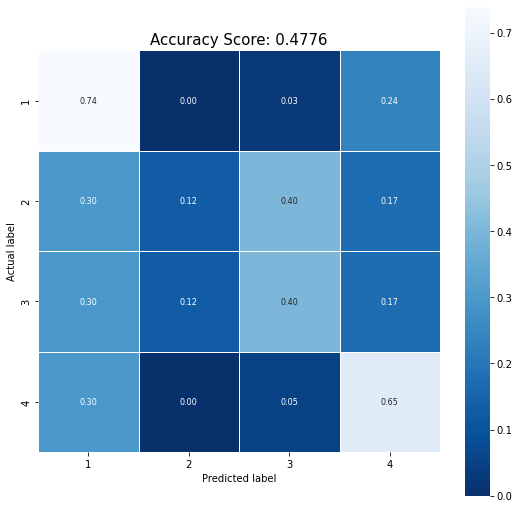

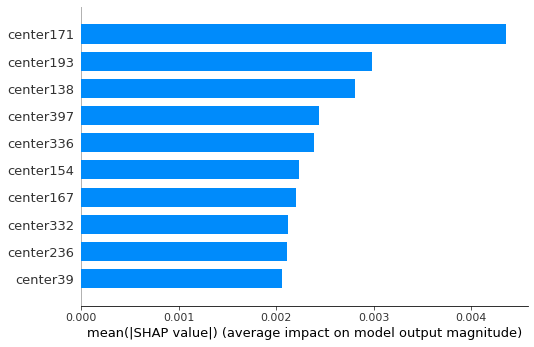

In [103]:
main_cv()

In [ ]:
cnn = keras.models.Sequential([
    Input(shape=x_train.shape[1:]),
    Dense(300, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100),
    Dense(4, activation='softmax')
])
cnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy')